## Import standard libraries

In [1]:
import torch
import torch.nn as nn  # we'll use this a lot going forward!
import torch.nn.functional as F

import numpy as np
import warnings

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import pyplot as plt, rc

# Import json library and create function to format dictionaries.
import json
format_json = lambda x: json.dumps(x, indent=4)

# Import pandas and set pandas DataFrame visualization parameters
from IPython.display import display
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Set rendering parameters to use TeX font if not working on Juno app.
from pathlib import Path
import os
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)
    
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: %s' % cwd)


Parent working directory: /Users/jjrr/Documents/SCA-Project/Tool


## Import user defined libraries

In [2]:
# Import custom libraries from local folder.
import sys
sys.path.append("..")

from library.irplib import utils, eda, config, sdg
from library.irplib import rnn

## Data preparation

### Import training dataset

In [3]:
# Import transformed training dataset
df = eda.import_cdm_data(os.path.join(cwd,'data','esa-challenge','train_data_transformed.csv'))

# Count number of CDMs available per event
nb_cdms = df.groupby(['event_id']).count()['time_to_tca'].to_numpy(dtype=np.int16)

# Define window size and number of events to forecast
seq_length = 5
events_to_forecast = 1
min_cdms = seq_length + events_to_forecast

print(f'Events suitable for training (More than {min_cdms-1} CDMs): {np.sum(nb_cdms>=min_cdms)}'
      f' ({np.sum(nb_cdms>=min_cdms)/len(nb_cdms)*100:5.1f}%)')
print(f'Time sequences with event_id integrity per feature: {np.sum(nb_cdms[nb_cdms>=min_cdms]-min_cdms)}')

# Count number of CDMs per event
ts_events  = df[['event_id', 'time_to_tca']].groupby(['event_id']).count().rename(columns={'time_to_tca':'nb_cdms'})

# Get events that have a minimum number of CDMs equal to the window_size + events_to_forecast
events_filter = list(ts_events[ts_events['nb_cdms']>=min_cdms].index.values)

# Redefine DataFrame to contain only events suitable for TSF to save memory
df = df[df['event_id'].isin(events_filter)]

# Show first data points to explore data types
display(df.head(10))
df.info()

Events suitable for training (More than 5 CDMs): 9400 ( 71.5%)
Time sequences with event_id integrity per feature: 94699


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
9,2,0.997639,2,-10.816161,-6.601713,13.293159,0.381700,0.71740,-0.289400,-0.070069,0.244292,0.022571,-0.68960,-0.197855,1.0,0.0,3.92,3.92,444,442,99.4,1.094,3.4505,0.638000,0.156500,0.000019,1.208407,0.000860,0.564323,-0.099768,0.357995,-0.122174,0.085472,-0.999674,0.121504,-0.999114,0.057809,-0.353866,-0.043471,-0.025138,0.087954,-0.430583,-0.088821,0.021409,UNKNOWN,180.0,2.0,13.87,13.87,15,15,100.0,1.838,NaN,0.040715,0.112876,0.000726,0.087532,0.001367,0.847990,-0.068526,0.636970,-0.038214,0.064305,-0.999989,0.036762,-0.996314,0.153806,-0.634961,-0.149627,0.715984,-0.159057,0.953945,0.156803,-0.723349,12.0,2.0,0.974572,1.002050,0.024863,1.112026,0.319779,-0.080044,-0.003155,0.057604,4.110620e+06,2.715773e+18,0.137597,0.346868,0.312163,0.659368,0.031019,0.336601,-0.117197,0.230077,-0.291892,-0.081841,-0.346900,-0.067535,0,0,0,0
10,2,0.955944,2,-10.850473,-6.603452,13.374242,0.382767,0.71740,-0.290275,-0.070336,0.244959,0.022571,-0.68960,-0.197855,1.0,0.0,3.86,3.86,444,442,99.4,1.099,3.4505,0.604200,0.180200,0.000017,1.208407,0.000861,0.564323,-0.005874,0.360471,-0.036075,-0.002789,-0.999876,0.035870,-0.997255,-0.068114,-0.357012,0.076754,-0.027154,0.084268,-0.442266,-0.085037,0.020991,UNKNOWN,180.0,2.0,13.87,13.87,15,15,100.0,1.838,NaN,0.040715,0.112876,0.000726,0.087532,0.001367,0.847990,-0.067750,0.636974,-0.038143,0.063521,-0.999989,0.036689,-0.996313,0.153053,-0.634998,-0.148865,0.715914,-0.158753,0.953971,0.156495,-0.723302,12.0,2.0,0.974579,1.002044,0.024863,1.112028,0.319783,-0.080044,-0.003155,0.050715,1.158624e+07,2.704770e+18,0.137291,0.346862,0.343134,0.659245,0.032259,0.336599,-0.086135,0.229954,-0.291868,-0.081850,-0.346051,-0.067537,0,0,0,0
11,2,0.895711,2,-30.000000,-6.217958,426.808532,0.313083,0.71735,-0.174700,-0.057516,0.200498,0.020571,-0.68957,-0.197860,1.0,0.0,3.85,3.85,447,445,99.4,1.113,3.4505,0.575950,0.163283,0.000016,1.208441,0.000862,0.564323,-0.222621,0.425875,-0.149746,0.206756,-0.999517,0.147289,-0.999479,0.191052,-0.423717,-0.175085,0.082662,0.017007,-0.405439,-0.018617,-0.083820,UNKNOWN,1.0,0.0,14.63,14.63,15,15,100.0,1.641,NaN,0.042499,0.095228,0.000712,0.087532,0.001297,0.848005,0.025977,0.563595,0.065183,-0.045196,-0.999602,-0.075887,-0.999774,-0.006036,-0.564147,0.025308,0.703561,-0.027022,0.916588,0.007301,-0.706289,12.0,2.0,0.974617,1.002059,0.024838,1.112860,0.319517,-0.080050,-0.002875,0.088636,3.780413e+06,7.644201e+13,0.143460,0.242464,0.300218,0.489541,0.037578,0.279063,-0.129056,0.060121,-0.286243,-0.186705,-0.345671,-0.102776,0,0,0,0
12,2,0.863193,2,-30.000000,-6.271078,181.496778,0.314033,0.71735,-0.175000,-0.057690,0.201104,0.020571,-0.68957,-0.197860,1.0,0.0,3.83,3.83,451,449,99.4,1.122,3.4479

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151099 entries, 9 to 162633
Columns: 103 entries, event_id to AP
dtypes: category(7), float64(88), int16(8)
memory usage: 106.7 MB


## Time-Series Forecasting problem

### Converting data from Pandas DataFrame to Time-Series Pytorch Tensors

In [4]:
# Get input variable features from config file.
features = list(dict.keys(config.get_features(**{'cluster':'coefficients', 'continuous':True, 'variable': True})))

print(utils.tabular_list(features))

# Check if file containing tensors is available in the data folder and load it
# tsf_tensors = torch.load(filepath) if os.path.exists(filepath) else {}
tsf_tensors = {}

# Iterate over all features to get the time series subsets
pb_features = utils.progressbar(iterations = range(len(features)), desc_loc='right')
for f in pb_features.iterations:

    # Initialize list of tensors for feature f
    feature = features[f]
    
    # Get filename and filepath and check if it already exists
    filename = f'ts_{seq_length}-{events_to_forecast}-{feature}.pt'
    filepath = os.path.join(cwd,'data','tensors', filename)

    if os.path.exists(filepath):
        # If tensors already exists, load them.
        description = f'> Loading tensors from feature {feature} ...'
        pb_features.refresh(i = f+1, description = description)
        
        tsf_tensors[feature] = torch.load(filepath)
    else:

        # If tensor do not exist for a feature, initialize and get all time-series
        tsf_tensors[feature] = []

        # Get full sequence from dataset and convert it to a tensor.
        feature_dtype = str(df[feature].dtype).lower()
        data = df[feature].to_numpy(dtype=feature_dtype)

        for e, event_id in enumerate(events_filter):

            # Print progress bar
            subprogress = (e+1)/len(events_filter)*100
            description = f'> Extracting sequences of time-series from feature {feature:<30s}  (Progress: {subprogress:5.1f}%)'
            pb_features.refresh(i = f+1, description = description)

            # Get full sequence from dataset and convert it to a tensor.
            event_filter = (df['event_id']==event_id)
            full_seq = torch.nan_to_num(torch.FloatTensor(data[event_filter]))

            # Add Time-Series subsets from full sequence tensor and add it to the list for the feature f
            tsf_tensors[feature] = tsf_tensors[feature] + rnn.event_ts_sets(full_seq, seq_length)

        # Save tensors containing all Time-Series subsets for training organised by feature.
        description = f'Saving tensors with sequences of time-series into external file {"."*(len(description)-64)}'
        torch.save(tsf_tensors[feature], os.path.join(cwd,'data','tensors', filename))
        pb_features.refresh(i = f+1, description = description)

    

t_cd_area..ver_mass    	c_cd_area..ver_mass    	
t_cr_area..ver_mass    	c_cr_area..ver_mass    	

> 100% |██████████| 4/4 | Remaining time: 00:00 (0.65 it/s) > Loading tensors from feature c_cr_area_over_mass ...


### Get Inputs and Outputs tensors from Time-Series

In [7]:
# Get inputs and outputs in the right shape to feed the LSTM model
tsf_data = rnn.tsf_iotensors(tsf_tensors, features, seq_length)
inputs  = tsf_data['inputs']  # Tensor with shape (batch_size, seq_length, input_size)
outputs = tsf_data['outputs'] # Tensor with shape (batch_size, input_size)

> 100% |██████████| 104099/104099 | Remaining time: 00:00 (37117.73 it/s) > Getting training and target tensors ...


In [8]:
batch = 1
print(inputs[batch, :, :]) # Inputs shape is (batch_size, seq_length, input_size)
print(outputs[batch])      # Outputs shape is (batch_size, input_size)

tensor([[0.6042, 0.1802, 0.0407, 0.1129],
        [0.5760, 0.1633, 0.0425, 0.0952],
        [0.5583, 0.1686, 0.0425, 0.0952],
        [0.5891, 0.2337, 0.0425, 0.0952],
        [0.5907, 0.2394, 0.0425, 0.0952]])
tensor([0.6338, 0.2657, 0.0425, 0.0952])


#### Training and test split on inputs/outputs tensors

In [9]:
train_split = 0.75

batch_size, seq_length, inputs_size = inputs.size()

train_size = int(((batch_size*train_split)//1000)*1000)
test_size = batch_size - train_size

print(f'Train size: {train_size} sequences \n Test size: {test_size} sequences')

X_train = inputs[:train_size-test_size]
X_test  = inputs[train_size-test_size:train_size]

y_train = outputs[:train_size-test_size]
y_test  = outputs[train_size-test_size:train_size]

Train size: 78000 sequences 
 Test size: 26099 sequences


### Neural network class definition and instanciation of the model

#### Definition of `LSTMtoLinear()` class

In [15]:
class LSTMtoLinear(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, 
                 num_layers = 1, batch_first = True, bidirectional = False):
        super(LSTMtoLinear, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = bidirectional

        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(
                input_size = input_size,    # 45, see the data definition
                hidden_size = hidden_size,  # Can vary
                num_layers = num_layers,
                batch_first = batch_first,
            ),
            'linear': nn.Linear(
                in_features = hidden_size * (2 if bidirectional else 1),
                out_features = output_size,
            )
        })

    def forward(self, inputs):

        seq_length, batch_size, input_size = inputs.size()
       
        # Data is fed to the LSTM
        #  - input: tensor shape depending on batch_first parameter:
        #       if False -> (seq_length, batch_size, input_size)
        #       if True  -> (batch_size, seq_length, input_size)
        #
        #  - output: tensor shape depending on batch_first parameter:
        #       if False -> (seq_length, batch_size, D * hidden_size) 
        #       if True  -> (batch_size, seq_length, D * hidden_size)
        #       where D=2 if bidirectional=True, D=1 otherwise.

        # The output from LSTM is one prediction per each input timestep, 
        # even though only the last timestep’s output is required.
        lstm_out, lstm_states = self.model['lstm'](inputs)
        # print(f'LSTM output size = {lstm_out.size()}')

        # Data is fed to the Linear layer:
        #  - input: (*, input_size), where * means any number of dimensions including None.
        #  - output: (*, output_size), where all but the last dimension are the same shape as the input.
        linear_out = self.model['linear'](lstm_out[:, -1, :])
        # print(f'Linear Regression output size = {linear_out.size()}')

        # # The prediction utilizing the whole sequence is the last one
        # y_pred = linear_out[:, :, -1].unsqueeze(-1)
        # print(f'y_pred={y_pred.size()}')

        return linear_out

### RNN model: `MultiEventPropagation` class

In [16]:

# Define Multivariate LSTM network class
class MultiEventPropagation(nn.Module):
    def __init__(self, input_size, output_size, layers, p = 0.5):
        super(MultiEventPropagation, self).__init__()
        self.input_size = input_size    # Number of input features
        self.output_size = output_size  # Number of outputs
        self.layers = layers    # Number of recurrent (stacked) layers
    
        layerlist = []
        n_in = input_size
        for l, layer in enumerate(layers):

            # On layer l, which contains n_neurons, perform the following operations:
            # 1. Apply Linear or LSTM to Linear neural network layer

            layer_type = layer['type']
            layer_neurons = layer['neurons']
            kwargs = layer.get('lstm_config', {'num_layers':1, 'batch_first': True})

            if layer_type == 'linear':
                layerlist.append(nn.Linear(n_in, layer_neurons['output']))
            else:

                layerlist.append(LSTMtoLinear(input_size = n_in, 
                                            hidden_size = layer_neurons['hidden'],
                                            output_size = layer_neurons['output'],
                                            num_layers = kwargs.get('num_layers', 1),
                                            batch_first = kwargs.get('batch_first', True)))

            # 2. Apply Hyperbolic Tangent activation function (al(z))
            layerlist.append(nn.Tanh())
            
            # 3. Normalize data using the n_neurons
            # layerlist.append(nn.BatchNorm1d(layer_neurons['output']))
            
            # 4. Cancel out a random proportion p of the neurons to avoid overfitting
            layerlist.append(nn.Dropout(p))

            # 5. Set new number of input features n_in for the next layer l+1.
            n_in = layer_neurons['output']

        # Set the last layer of the list which corresponds to the final output
        layerlist.append(nn.Linear(n_in, output_size))

        # Instantiate layers as a Neural Network sequential task
        self.layers = nn.Sequential(*layerlist)
        
    def forward(self, inputs): 

        # Process all data points with the layers functions (sequential of operations)
        outputs = self.layers(inputs)
        
        return outputs

In [17]:
# Instanciate model with required inputs.
torch.manual_seed(42)

layers = [{'type':'linear', 'neurons':{'output':200}},
          {'type':'lstm', 'neurons':{'output':400, 'hidden': 400}},
          {'type':'linear', 'neurons':{'output':200}}]

model = MultiEventPropagation(input_size = len(features),
                              output_size = len(features),
                              layers = layers)

# Define criterion, optimizer, and scheduler (dynamic learning rate adapter)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)

# Print model
print(model)

MultiEventPropagation(
  (layers): Sequential(
    (0): Linear(in_features=4, out_features=200, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): LSTMtoLinear(
      (model): ModuleDict(
        (lstm): LSTM(200, 400, batch_first=True)
        (linear): Linear(in_features=400, out_features=400, bias=True)
      )
    )
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=200, out_features=4, bias=True)
  )
)


## Model training

In [18]:
import torch.utils.data as torch_data
 

loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle=True, batch_size=500)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation
    if epoch % 100 != 0: continue

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(criterion(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(criterion(y_pred, y_test))
    print(f'Epoch {epoch}: Train RMSE {train_rmse:10.4f}, Test RMSE {test_rmse:10.4f}')

LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])
LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])
LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])
LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])
LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])
LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])
LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])
LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])
LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])
LSTM output size = torch.Size([500, 5, 400])
Linear Regression output size = torch.Size([500, 400])


KeyboardInterrupt: 

In [73]:
import time
start_time = time.time()


epochs = 100
batch_size = 500

# Initialize array of inf values for losses
losses = np.ones(epochs)*np.inf
lr = np.zeros(epochs)

loader = torch_data.DataLoader(torch_data.TensorDataset(X_train, y_train), shuffle = True, batch_size = batch_size)

# Iterate over all remaining features to get the time series subsets
pb_epochs = utils.progressbar(range(epochs), description='Training Conjunction Event Propagation model ...', desc_loc='right')

for e in pb_epochs.iterations:
    
    lr[e] = rnn.get_lr(optimizer)
    model.train()

    # Train model by passing n batches depending on the batch_size
    batches = range(0, len(X_train), batch_size)
    batch_losses = np.ones(len(batches))*np.inf

    for b, batch in enumerate(batches):
        
        # Get inputs and outputs for batch b
        upper_limit = batch+batch_size if batch+batch_size<len(inputs_train) else len(inputs_train)
        X_batch = X_train[batch:upper_limit]
        y_batch = y_train[batch:upper_limit]  
        
        # Reset Gradient from the optimizer (hidden and cell states)
        optimizer.zero_grad()
        
        # Initialize hidden state and compute outputs
        y_pred = model(X_batch) 
        
        # Compute loss using the outputs for the batch b and store values in array
        loss = criterion(y_pred, y_batch)  
        batch_losses[b] = loss.detach().numpy()
        
        # Back propagate loss and adjust parameters of the optimizer
        loss.backward()
        optimizer.step()

    losses[e] = batch_losses[-1] 

    # Update progress bar
    description = f'Training Conjunction Event Propagation model | Learning rate = {lr[e]:.2e} | MSE loss = {losses[e]:10.8f} -> sqrt(MSE) = {np.sqrt(losses[e]):10.8f}')
    pb_epochs.refresh(e+1, description = description)

    #if lr[e]<1e-6: break
    scheduler.step(loss)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Extracting sequences of time-series ...:   0%|          | 0/100 [00:00<?, ?it/s]

torch.Size([500, 5, 4])
LSTM output size = torch.Size([5, 500, 400])
Transformed LSTM output size = torch.Size([5, 400])


TypeError: forward() takes 2 positional arguments but 3 were given

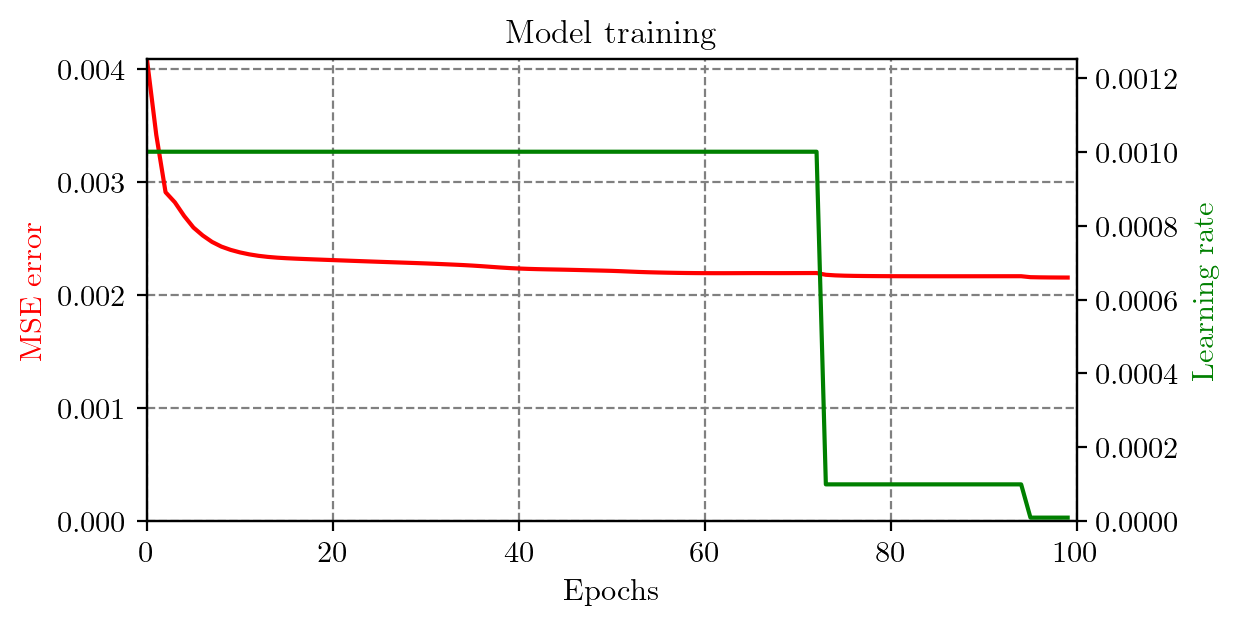

In [13]:
fig, ax1 = plt.subplots(figsize=(6,3))
plt.title(r'Model training', fontsize=12)
ax2 = ax1.twinx()
ax1.set_xlim(0, epochs)
ax1.set_ylim(0,np.max(losses))
ax2.set_ylim(0,np.max(lr)*1.25)
ax1.plot(range(0,epochs), losses, 'r-', label=r'MSE loss')
ax2.plot(range(0,epochs), lr, 'g-', label=r'Learning rate')

ax1.set_xlabel(r'Epochs')
ax1.set_ylabel(r'MSE error', color='r')
ax2.set_ylabel(r'Learning rate', color='g')
ax1.grid(True, linestyle='--', c='grey')
plt.show()




In [14]:
model.init_hidden(inputs_test[:1].size(0))
forecast_val = model(inputs_test[:1])
print(features)
print(inputs_test[0])
print(forecast_val[0])
print(outputs_test[0])

# Evaluate entire dataset
with torch.no_grad():

    model.init_hidden(inputs_test.size(0))
    forecast_val = model(inputs_test)
    loss = criterion(forecast_val, outputs_test)
print(f'MSE loss on test dataset: {loss:.8f}')

['t_cd_area_over_mass', 't_cr_area_over_mass', 'c_cd_area_over_mass', 'c_cr_area_over_mass']
tensor([[0.1924, 0.0000, 0.0005, 0.0000],
        [0.1961, 0.0000, 0.0007, 0.0000],
        [0.1980, 0.0000, 0.0009, 0.0000],
        [0.1919, 0.0000, 0.0010, 0.0000],
        [0.1943, 0.0000, 0.0009, 0.0000]])
tensor([ 1.9661e-01,  1.9821e-02,  7.9015e-04, -1.4404e-04],
       grad_fn=<SelectBackward0>)
tensor([0.1953, 0.0000, 0.0007, 0.0000])
MSE loss on test dataset: 0.00286999


# Tests

#### RNN with a single LSTM-Linear layer.

In [ ]:
# Define Multivariate LSTM network class
class EventPropagation(nn.Module):
    def __init__(self,input_size, hidden_size, output_size, seq_length, num_layers=1):
        super(EventPropagation, self).__init__()
        self.input_size = input_size    # Number of input features
        self.hidden_size = hidden_size  # Number of hidden neurons
        self.output_size = output_size  # Number of outputs
        self.num_layers = num_layers    # Number of recurrent (stacked) layers
        self.seq_length = seq_length
    
        self.lstm = nn.LSTM(input_size = self.input_size, 
                            hidden_size = self.hidden_size,
                            num_layers = self.num_layers,
                            batch_first = True)
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.linear = nn.Linear(self.hidden_size*self.seq_length, 
                                self.output_size)
    
    
    def forward(self, inputs):        
        batch_size, seq_length, input_size = inputs.size()
        
        lstm_out, lstm_states = self.lstm(inputs)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        inputs = lstm_out.contiguous().view(input_size,-1)
        outputs = self.linear(inputs)
        
        return outputs

In [ ]:
# Instanciate model with required inputs.
torch.manual_seed(42)
model = rnn.EventPropagation(input_size = len(features), 
                         hidden_size = 100,
                         output_size = len(features),
                         seq_length = seq_length)

# Define criterion, optimizer, and scheduler (dynamic learning rate adapter)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1)

# Print model
print(model)

EventPropagation(
  (lstm): LSTM(4, 100, batch_first=True)
  (linear): Linear(in_features=500, out_features=4, bias=True)
)


In [ ]:
# A batch is in shape [batches, batch_size, seq_length, input_size]  
x=torch.Size([128, 30, 12, 45])
y=torch.Size([128, 30, 1, 1])

class MockupModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(
                input_size=x_features,    # 45, see the data definition
                hidden_size=hidden_size,  # Can vary
            ),
            'linear': nn.Linear(
                in_features=hidden_size,
                out_features=1)
        })

    def forward(self, x):

        # From [batches, batch_size, seq_length, input_size]
        # to [seq_length, batch_size, input_size]
        x = x.view(x_seq_len, -1, x_features)
       
        # Data is fed to the LSTM
        out, _ = self.model['lstm'](x)
        print(f'lstm output={out.size()}')

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.view(x_batches, x_seqs, x_seq_len, -1)
        print(f'transformed output={out.size()}')

        # Data is fed to the Linear layer
        out = self.model['linear'](out)
        print(f'linear output={out.size()}')

        # The prediction utilizing the whole sequence is the last one
        y_pred = out[:, :, -1].unsqueeze(-1)
        print(f'y_pred={y_pred.size()}')

        return y_pred